In [19]:
import numpy as np
import os
import pandas as pd
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
import lightgbm as lgb
from joblib import load, dump
from sklearn.metrics import classification_report
from itertools import chain, combinations

metricas_analisis = [
    "frame_count", "perclos", "mean_ear", "current_time_closed_eyes", "blinks_per_minute",
    "yawns_per_minute", "head_nods_per_minute", "mean_blink_time", "head_nod", "yawn", "open_eyes", "drowsiness",
    "ear", "pitch", "yaw", "mar", "blink_frequency"
]
source_folder = "NTHUDDD_dataset2_step2_600/"
train_path = f"{source_folder}train/"
test_path = f"{source_folder}test/"
label = "drowsiness"
train_df_list = []
test_df_list = []
for filename in os.listdir(train_path):
    if "night" not in filename:
        file = os.path.join(train_path, filename)
        if os.path.isfile(file) and filename[-4:] == ".csv" and filename != "big_df.csv":
            df = pd.read_csv(file)[metricas_analisis]

            file_data = filename.split("_")
            df["subject"] = filename[:3]
            df["scenario"] = file_data[1]
            df["state"] = file_data[2][:-4]
            df["id"] = df['subject'] + df['scenario'] + df['state']
            train_df_list.append(df)

for filename in os.listdir(test_path):
    if "night" not in filename:
        file = os.path.join(test_path, filename)
        if os.path.isfile(file) and filename[-4:] == ".csv" and filename != "big_df.csv":
            df = pd.read_csv(file)[metricas_analisis]
            
            file_data = filename.split("_")
            df["subject"] = filename[:3]
            df["scenario"] = file_data[1]
            df["state"] = file_data[2][:-4]
            df["id"] = df['subject'] + df['scenario'] + df['state']
            test_df_list.append(df)
train_big_df = pd.concat(train_df_list)
test_big_df = pd.concat(test_df_list)
# big_df = big_df.drop("Unnamed: 0.1", axis=1)
# train_big_df.head()
test_big_df.head()

,frame_count,perclos,mean_ear,current_time_closed_eyes,blinks_per_minute,yawns_per_minute,head_nods_per_minute,mean_blink_time,head_nod,yawn,...,drowsiness,ear,pitch,yaw,mar,blink_frequency,subject,scenario,state,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0.209737,103.179336,19.935289,0.215266,0.0,003,noglasses,mix,003noglassesmix
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0.211037,103.228668,19.945841,0.215521,0.0,003,noglasses,mix,003noglassesmix
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0.213595,103.431653,19.996262,0.216055,0.0,003,noglasses,mix,003noglassesmix
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0.207967,103.932718,19.822447,0.224169,0.0,003,noglasses,mix,003noglassesmix
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,...,0,0.204944,104.697250,19.866714,0.232029,0.0,003,noglasses,mix,003noglassesmix


In [26]:
filtered_train_big_df = train_big_df.copy()
filtered_test_big_df = test_big_df.copy()
# filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["frame_count"] > 200]
filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["scenario"] == "noglasses"]
filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["subject"].isin(["001", "008", "009", "013", "023", "034", "035", "036"]) ]
# filtered_big_df = filtered_big_df[filtered_big_df["subject"].isin(["011"]) ]

# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["frame_count"] > 200]
filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["scenario"] == "noglasses"]
# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["subject"].isin(["011", "016", "021"])]
# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["subject"].isin(["003", "010", "011", "014", "016", "017", "018", "019", "021", "025", "027", "028", "029", "037"])]
filtered_train_big_df.groupby(["subject", label]).mean()

frame_count   perclos  mean_ear  current_time_closed_eyes  \
subject drowsiness                                                              
001     0           1052.102407  0.169122  0.230323                  0.039119   
        1           1276.309729  0.343809  0.243348                  0.731075   
008     0           1074.674378  0.055559  0.215494                  0.022363   
        1           1427.010122  0.274989  0.290838                  0.941437   
009     0           1074.377161  0.112762  0.267115                  0.076828   
        1           1379.420230  0.458210  0.296821                  1.627446   
013     0           1177.155239  0.098367  0.192082                  0.049026   
        1           1413.869310  0.318778  0.265582                  0.510348   
023     0           1077.808516  0.184413  0.206010                  0.209900   
        1           1362.197501  0.358286  0.255342                  0.598745   
034     0           1040.969997  0.104189  0.199750                  0.028838   
        1           1510.687126  0.208818  0.295333                  0.156189   
035     0           1069.825975  0.053482  0.132989                  0.010087   
        1           1394.054435  0.399836  0.214993                  1.873746   
036     0           1141.401877  0.142266  0.204683                  0.011718   
        1           1377.280821  0.422461  0.213860                  1.260380   

                    blinks_per_minute  yawns_per_minute  head_nods_per_minute  \
subject drowsiness                                                              
001     0                   11.135941          0.000000              0.387353   
        1                    9.983030          0.541828              0.398196   
008     0                    4.635115          0.109341              0.000000   
        1                    2.055013          0.344653              0.141711   
009     0                    4.497416          0.006331              0.146092   
        1                    6.893705          0.438131              0.397413   
013     0                    5.443380          0.000000              0.000000   
        1                    5.627489          0.667281              0.304807   
023     0                    6.794996          0.000000              0.000000   
        1                    4.996233          0.833634              0.542959   
034     0                    7.623205          0.072392              0.000000   
        1                    7.964287          0.638507              0.591417   
035     0                    4.189456          0.000000              0.000000   
        1                    1.598734          0.865607              0.537378   
036     0                    7.696385          0.205054              0.072526   
        1                    6.311624          0.500468              0.351343   

                    mean_blink_time       ear       pitch        yaw  \
subject drowsiness                                                     
001     0                  0.315423  0.270733   95.105396  30.991209   
        1                  0.785776  0.205822   91.559326  29.649814   
008     0                  0.135266  0.260461   80.395814  17.201944   
        1                  2.066750  0.205851   79.740488  17.630816   
009     0                  0.399340  0.336087   90.288918  23.802120   
        1                  1.462626  0.227502   86.542689  22.045594   
013     0                  0.254354  0.233763  108.653024  23.235451   
        1                  1.219031  0.198388   97.258489  27.225487   
023     0                  0.463610  0.251198   95.184977  23.005551   
        1                  1.539379  0.208275   84.453754  15.186149   
034     0                  0.212788  0.277625   92.282712  34.190768   
        1                  0.567943  0.236052   87.432404  27.191411   
035     0                  0.154175  0.300257   99.775012  34.703461   
        1             

In [73]:
print(f"TOTAL NUM ROWS: {filtered_train_big_df.shape[0]}")
print(f"NUM NULL ROWS: {filtered_train_big_df.shape[0] - filtered_train_big_df.dropna().shape[0]}")
train_big_df_nonull = filtered_train_big_df.dropna().sample(frac=1).reset_index(drop=True)
train_big_df_nonull["open_eyes"] = train_big_df_nonull["open_eyes"].astype("int")
train_big_df_nonull["head_nod"] = train_big_df_nonull["head_nod"].astype("int")
train_big_df_nonull["yawn"] = train_big_df_nonull["yawn"].astype("int")


print(f"TOTAL NUM ROWS: {filtered_test_big_df.shape[0]}")
print(f"NUM NULL ROWS: {filtered_test_big_df.shape[0] - filtered_test_big_df.dropna().shape[0]}")
test_big_df_nonull = filtered_test_big_df.dropna().sample(frac=1).reset_index(drop=True)
test_big_df_nonull["open_eyes"] = test_big_df_nonull["open_eyes"].astype("int")
test_big_df_nonull["head_nod"] = test_big_df_nonull["head_nod"].astype("int")
test_big_df_nonull["yawn"] = test_big_df_nonull["yawn"].astype("int")

TOTAL NUM ROWS: 79534
NUM NULL ROWS: 2549
TOTAL NUM ROWS: 127047
NUM NULL ROWS: 5230


In [86]:
variable = "drowsiness"
variable2 = "perclos"
x = (test_big_df_nonull[variable])
y = (test_big_df_nonull[variable2])

data = test_big_df_nonull[[variable, variable2]]
print(data)

        drowsiness  blink_frequency
0                1         0.003411
1                0         0.006164
2                1         0.015385
3                0         0.002230
4                1         0.015058
...            ...              ...
121812           0         0.007064
121813           0         0.017873
121814           1         0.020110
121815           0         0.010197
121816           0         0.018519

[121817 rows x 2 columns]


In [87]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

<AxesSubplot:>

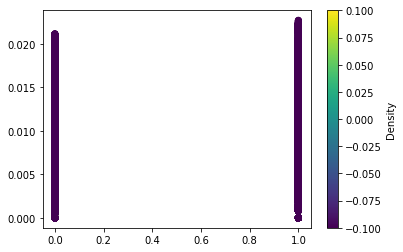

In [88]:
density_scatter(x, y, bins = [10000,10000], sort=True)